<font color='orange' size=6>Authorship, Manning Live Project, Section 3</font>  
Mar 15, 2021
<hr>

Note:  starting with Notebook from 2, and modifying, paring down and then building up, since we need to use what was at the end of that

# Imports

In [222]:
import os
import re
from chardet.universaldetector import UniversalDetector
import pickle
import glob
import chardet
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
from typing import NamedTuple, List
import random
from matplotlib import pyplot as plt
import seaborn as sns
import time

# from project 1; for application of that code below
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB


# Config including paths, globals, constants

In [2]:
# check current working dir and create dir for files
cur_dir = os.getcwd()
cur_dir

'/Users/bradgreenwald/projects/manning/Author_ID_Live_Project'

In [3]:
# path to directory containing xml files with blogs
xml_path = os.path.join(os.getcwd(), 'data', 'blogs')
xml_path

'/Users/bradgreenwald/projects/manning/Author_ID_Live_Project/data/blogs'

In [4]:
# create list of xml_files, recalling that mac creates files in the folder
xml_filenames = [fname for fname in os.listdir(xml_path) if fname.endswith('xml')]
len(xml_filenames)

19320

In [77]:
%config InlineBackend.figure_format = 'retina'
sns.set()

# Helper Classes, Functions; also Hoisted Functions

In [5]:
dirp = lambda x: [d for d in dir(x) if not d.startswith('_')]
from pprint import pprint as pp

# Pickled data

In [6]:
# xml files byte content in dict keyed by filename
with open(os.path.join(os.getcwd(), 'data', 'xml_files.pickle'), 'rb') as fh:
    xml_files = pickle.load(fh)

In [7]:
# decoded text dataframe with filenames
with open(os.path.join(cur_dir, 'data', 'df_txt.pickle'), 'rb') as fh:
    df_txt = pickle.load(fh)

In [8]:
df_txt.sample()

,txt,fnames
3361,"<Blog>\r\n\r\n<date>16,February,2004</date>\r\...",1233897.male.17.Technology.Virgo.xml


In [9]:
# cleaned post processed posts with metadata
with open(os.path.join(cur_dir, 'data', 'df_allclean.pickle'), 'rb') as fh:
    df_allposts = pickle.load(fh)

In [11]:
df_allposts.sample()

,auth_id,gender,age,industry,star_sign,post,clean
303982,2931757,female,13,Arts,Sagittarius,"\n\n\t \n well, I have found out how to d...","well, I have found out how to do many things ..."


# From end of part 2; applying code to cleaned posts

- Using the list of authors from part 1, get all their posts
- sample 10 for each author (from the solution template)
- create train-test split in portion of dataset (some columns)
- create pipeline
- apply pipeline

In [12]:
df_allposts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658805 entries, 0 to 658804
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   auth_id    658805 non-null  object
 1   gender     658805 non-null  object
 2   age        658805 non-null  object
 3   industry   658805 non-null  object
 4   star_sign  658805 non-null  object
 5   post       658805 non-null  object
 6   clean      658805 non-null  object
dtypes: object(7)
memory usage: 35.2+ MB


In [13]:
# cast auth_id and age as ints
df_allposts['auth_id'] = df_allposts['auth_id'].astype(int)
df_allposts['age'] = df_allposts['age'].astype(int)

## Test and tune the process for the original set of authors

In [14]:
authors = [3574878, 2845196, 3444474, 3445677, 828046, 
                       4284264, 3498812, 4137740, 3662461, 3363271]

From testing below:  f1: .7523

In [15]:
auth10_posts = df_allposts[df_allposts['auth_id'].isin(authors)]

In [16]:
auth10_posts.shape

(153, 7)

In [17]:
auth10_posts.sample(10)

,auth_id,gender,age,industry,star_sign,post,clean
91099,3444474,female,17,Student,Sagittarius,"\n\n \n I got a pedicure, my nails ar...","I got a pedicure, my nails are pink! :D I mig..."
91075,3444474,female,17,Student,Sagittarius,"\n\n \n Went to a party tonight, that...","Went to a party tonight, that was cool. It wa..."
568705,828046,male,25,Arts,Gemini,\n\n\t \n Those who are the least concern...,Those who are the least concerned with the ha...
91107,3444474,female,17,Student,Sagittarius,\n\n \n I think I'm going to see Catw...,I think I'm going to see Catwoman later with ...
91142,3444474,female,17,Student,Sagittarius,"\n\n \n Yeah ok, so I was late leavin...","Yeah ok, so I was late leaving my house, and ..."
91125,3444474,female,17,Student,Sagittarius,"\n\n \n Holy crap, Pride and Prejudi...","Holy crap, Pride and Prejudice was fucking. a..."
91134,3444474,female,17,Student,Sagittarius,"\n\n \n Saw the Bourne Supremacy, it ...","Saw the Bourne Supremacy, it rocked my socks ..."
91128,3444474,female,17,Student,Sagittarius,"\n\n \n Aaah, after lunch, when I onl...","Aaah, after lunch, when I only have two more ..."
91087,3444474,female,17,Student,Sagittarius,"\n\n \n I'm swimming in this desire, ...","I'm swimming in this desire, my head is falli..."
91070,3444474,female,17,Student,Sagittarius,\n\n \n //rocks out to my favorite I...,//rocks out to my favorite Injected song. :ro...


- Highly Imbalanced

In [25]:
all_data = auth10_posts['clean']
all_labels = auth10_posts['auth_id']

## Recreating a few pipelines with diff models

In [231]:
model_types = [SVC(kernel='rbf'), SVC(kernel='linear'), BernoulliNB]
model_names = ['svc_rbf', 'svc_lin', 'bernoulli']

In [18]:
# Setting random_state because otherwise the f1 scores continually change
auth_clf1 = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 5), analyzer='char', use_idf='false')),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                         alpha=1e-3, random_state=42,
                         max_iter=5, tol=None)),
])

In [19]:
# Pipeline using SGD with default hyperparameters
auth_clf2 = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 5), analyzer='char', use_idf='true')),
    ('clf', SGDClassifier(random_state=42)),
])

In [20]:
# Pipeline using diff ngram range
auth_clf3 = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 4), analyzer='char', use_idf='false')),
    ('clf', SGDClassifier(random_state=42)),
])

In [226]:
# Pipeline allowing for diff clfs
def build_pipeline(model):
    auth_clf = Pipeline([
        ('vect', TfidfVectorizer(ngram_range=(1, 4), analyzer='char', use_idf='false')),
        ('clf', model),
    ])
    return auth_clf

## Func to create train/test split, train model, test and eval model

In [21]:
def pipeline_to_f1_scores(samples, clfs):
    """Train and test model clfs on the data diff_samples; print f1 score, confusion matrix, and classification
    report.  
    
        Args:  
            diff_samples: pd.DataFrame with at least 'auth_id' and 'post' columns
            clfs: sklearn model; can be just model, or a pipeline
        
        Return: f1-score
    """
    print(f'{len(samples) = }')
    
    data = samples['clean'].values
    labels = samples['auth_id'].values
    
    # Stratifying because of of widespread class imbalance
    df_auth_train, df_auth_test, labels_train, labels_test = train_test_split(data, labels, 
                                                                          test_size=0.4, random_state=42, stratify=labels)
    # Train model and get predictions
    clfs.fit(df_auth_train, labels_train)
    preds = clfs.predict(df_auth_test)
    
    # calculate the f1-scores
    f1 = metrics.f1_score(labels_test, preds, average='weighted', zero_division=1)
    
    # print results
    print(f'f-scores')
    print(f'\tWeighted f1: {f1:.4}\n')
    
    # Confusion matrix and classification report are useful to see if mistakes are following pattern
    print(metrics.confusion_matrix(labels_test, preds))
    
    # classification report is useful to see support
    print(metrics.classification_report(labels_test, preds, zero_division=1))
    
    return f1

In [22]:
# Testing on 10
f1_score = pipeline_to_f1_scores(auth10_posts, auth_clf3)

len(samples) = 153
f-scores
	Weighted f1: 0.7435

[[ 1  0  0  2  0  2  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0 33  0  0  0  0  0  0]
 [ 0  0  0  0  1  1  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  1]
 [ 0  0  0  1  0  0  5  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2]]
              precision    recall  f1-score   support

      828046       1.00      0.20      0.33         5
     2845196       1.00      1.00      1.00         5
     3363271       1.00      1.00      1.00         2
     3444474       0.79      1.00      0.88        33
     3445677       1.00      0.50      0.67         2
     3498812       0.00      0.00      0.00         4
     3574878       1.00      0.83      0.91         6
     3662461       1.00      0.00      0.00         2
     4137740       1.00      0.00      0.00         1
     4284264       0.67      1.00      0.80         2

    accuracy           

I think **weighted** f1 is best score, because it accounts for class imbalances and classes with zero samples 
- Also consider laplacian smoothing - adding one to the numerator and denominator

In [249]:
f1_score

0.7532626307261746

In [228]:
# placeholder cell to get help with shift-tab
metrics.confusion_matrix
metrics.f1_score

<function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>

Q:  Why does the confusion matrix not include 153 entries? 
- The number discrepancy:  because of the test/train split. The test is only 30% of 153, which is 51. 

# Start Experimenting with diff sets of authors

Consider the timing here.  for less than 200 posts, a bit less than 1 second. (well 70% of that bc of train test split)
So 1000 posts would be one second, and 5000 posts would be 5 seconds? 

## Duplicating function without print statements

In [235]:
def pipeline_to_f1_scores(samples, clfs, cross_val=False):
    """Train and test model clfs on the data diff_samples; print f1 score, confusion matrix, and classification
    report.  
    
        Args:  
            samples: pd.DataFrame with at least 'auth_id' and 'post' columns
            clfs: sklearn model; can be just model, or a pipeline
        
        Return: f1-score
    """    
    data = samples['clean'].values
    labels = samples['auth_id'].values
    
    
    if cross_val:
        # cross val code
        f1_scores = cross_val_score(clfs, data, labels, cv=3)
        return f1_scores
    else:
        # Stratifying because of of widespread class imbalance
        df_auth_train, df_auth_test, labels_train, labels_test = train_test_split(data, labels, 
                                                                              test_size=0.4, random_state=42, stratify=labels)
        # Train model and get predictions
        clfs.fit(df_auth_train, labels_train)
        preds = clfs.predict(df_auth_test)

        # calculate the f1-scores
        f1 = metrics.f1_score(labels_test, preds, average='weighted', zero_division=1)
    
        return f1

In [235]:
def pipeline_to_f1_scores(samples, clfs, cross_val=False):
    """Train and test model clfs on the data diff_samples; print f1 score, confusion matrix, and classification
    report.  
    
        Args:  
            samples: pd.DataFrame with at least 'auth_id' and 'post' columns
            clfs: sklearn model; can be just model, or a pipeline
        
        Return: f1-score
    """    
    data = samples['clean'].values
    labels = samples['auth_id'].values
    
    
    if cross_val:
        # cross val code
        f1_scores = cross_val_score(clfs, data, labels, cv=3)
        return f1_scores
    else:
        # Stratifying because of of widespread class imbalance
        df_auth_train, df_auth_test, labels_train, labels_test = train_test_split(data, labels, 
                                                                              test_size=0.4, random_state=42, stratify=labels)
        # Train model and get predictions
        clfs.fit(df_auth_train, labels_train)
        preds = clfs.predict(df_auth_test)

        # calculate the f1-scores
        f1 = metrics.f1_score(labels_test, preds, average='weighted', zero_division=1)
    
        return f1

In [199]:
# Pipeline using diff ngram range
auth_clf3 = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 4), analyzer='char', use_idf='false')),
    ('clf', SGDClassifier(random_state=42)),
])

## Prepare set of author_ids for random sampling

In [23]:
auth_ids = df_allposts['auth_id'].value_counts().index.tolist()
len(auth_ids)

19320

In [24]:
# Create Dataframe with only needed columns
df_data = df_allposts[['auth_id', 'clean']]
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658805 entries, 0 to 658804
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   auth_id  658805 non-null  int64 
 1   clean    658805 non-null  object
dtypes: int64(1), object(1)
memory usage: 10.1+ MB


In [25]:
# dict to hold f1 scores (and sample sizes) for author sets by size (e.g. 20, 30, 40)
f1_dict = dict()

In [229]:
# dict for diff models
f_model_dict = dict()

In [30]:
# Lets set size of random set and add to dict for collecting f1-scores
n = 10
if n not in f1_dict:
    f1_dict[n] = []

- PROBLEM:  Single post authors mess up train-test split

Need to make sure that there are at least 2 samples per author.  Or maybe if there is only one, we can split it in middle?  
We'll try it to see if it works
Or, we could just duplicate the post? That's be much easier

In [200]:
# replace all 1 post authors
def replace_1posters(auths_rand):
    """Replace any auth_ids that have only 1 post"""

    df_rand_auths = df_data[df_data['auth_id'].isin(auths_rand)]
    for i, auth in enumerate(auths_rand):
        if df_rand_auths[df_rand_auths['auth_id']==auth].shape[0] == 1:
            new_auth=auth
            while df_data[df_data['auth_id']==new_auth].shape[0] == 1:
                new_auth = random.sample(auth_ids, 1)[0]C
            auths_rand[i] = new_auth
    df_rand_auths = df_data[df_data['auth_id'].isin(auths_rand)]
    return df_rand_auths

In [210]:
# replace all 2 or less post authors
def replace_2posters(auths_rand):
    """Replace any auth_ids that have only 1 post"""

    df_rand_auths = df_data[df_data['auth_id'].isin(auths_rand)]
    for i, auth in enumerate(auths_rand):
        if df_rand_auths[df_rand_auths['auth_id']==auth].shape[0] <= 2:
            new_auth=auth
            while df_data[df_data['auth_id']==new_auth].shape[0] <= 2:
                new_auth = random.sample(auth_ids, 1)[0]
            auths_rand[i] = new_auth
    df_rand_auths = df_data[df_data['auth_id'].isin(auths_rand)]
    return df_rand_auths

In [203]:
# Main Loop: get n random auths; run pipeline and put f1 score into dict. 
def iter_n_auths(num_auths=10, auth_clf=auth_clf3, num_iters=10):
    """Fit, predict and evaluate auth_clf model applied to posts for random set of n authors"""
    times = []
    if num_auths not in f1_dict:
        f1_dict[num_auths] = []
    # Number of iterations set here
    for _ in range(num_iters):
        start = time.time()
        auths_rand = random.sample(auth_ids, num_auths)
        df_rand_auths = replace_1posters(auths_rand)
        f1 = pipeline_to_f1_scores(df_rand_auths, auth_clf3)
        
        f1_dict[num_auths].append((round(f1, 4), df_rand_auths.shape[0]))
        end = time.time()
        times.append(end-start)
    return times

In [217]:
cross_val_scores = []

# CROSS VAL: Main Loop: get n random auths; run pipeline and put f1 score into dict. 
def iter_n_auths(num_auths=10, auth_clf=auth_clf3, num_iters=5):
    """Fit, predict and evaluate auth_clf model applied to posts for random set of n authors"""
    times = []
#     if num_auths not in f1_dict:
#         f1_dict[num_auths] = []
    # Number of iterations set here
    for _ in range(num_iters):
        start = time.time()
        auths_rand = random.sample(auth_ids, num_auths)
        df_rand_auths = replace_2posters(auths_rand)
        f1_scores = pipeline_to_f1_scores(df_rand_auths, auth_clf3, cross_val=True)
        cross_val_scores.append(f1_scores)
        end = time.time()
        times.append(end-start)
    return times

In [242]:
f_model_dict = dict()

In [245]:
# For diff models use a diff dict Main Loop: get n random auths; run pipeline and put f1 score into dict. 
def iter_n_auths_models(model_name, clf, num_auths=20, num_iters=10):
    """Fit, predict and evaluate auth_clf model applied to posts for random set of n authors"""
    if model_name not in f_model_dict:
        f_model_dict[model_name] = []
    # Number of iterations set here
    for i in range(num_iters):
        print(f'iter: {i} {model_name = }')
        auths_rand = random.sample(auth_ids, num_auths)
        df_rand_auths = replace_1posters(auths_rand)
        f1 = pipeline_to_f1_scores(df_rand_auths, clf)
        f_model_dict[model_name].append((round(f1, 4), df_rand_auths.shape[0]))



## Checking time

In [218]:
elapsed = iter_n_auths(20)

In [219]:
cross_val_scores

[array([0.84615385, 0.87102178, 0.83752094]),
 array([0.7253886 , 0.71354167, 0.67708333]),
 array([0.73127753, 0.75770925, 0.5840708 ]),
 array([0.75538462, 0.78890601, 0.7550077 ]),
 array([0.57391304, 0.69565217, 0.62280702])]

In [220]:
[round(np.mean(cvs), 4) for cvs in cross_val_scores]

[0.8516, 0.7053, 0.691, 0.7664, 0.6308]

In [221]:
[round(tim, 4) for tim in elapsed], round(sum(elapsed), 4)

([6.3159, 6.5673, 5.1933, 12.8969, 2.7877], 33.7611)

In [190]:
for num in f1_dict:
    print(f'{num=} {len(f1_dict[num])}')

num=10 40
num=20 40
num=30 40
num=40 50
num=5 30


## Try using diff models

In [ ]:
clf.predict_proba

In [250]:
dirp(clf)

['classes_',
 'decision_function',
 'fit',
 'fit_predict',
 'fit_transform',
 'get_params',
 'inverse_transform',
 'memory',
 'n_features_in_',
 'named_steps',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'score',
 'score_samples',
 'set_params',
 'steps',
 'transform',
 'verbose']

In [249]:
whos

Variable                Type              Data/Info
---------------------------------------------------
BernoulliNB             ABCMeta           <class 'sklearn.naive_bayes.BernoulliNB'>
KFold                   ABCMeta           <class 'sklearn.model_selection._split.KFold'>
List                    _GenericAlias     typing.List
MultinomialNB           ABCMeta           <class 'sklearn.naive_bayes.MultinomialNB'>
NamedTuple              NamedTupleMeta    <class 'typing.NamedTuple'>
Perceptron              ABCMeta           <class 'sklearn.linear_mo<...>._perceptron.Perceptron'>
Pipeline                ABCMeta           <class 'sklearn.pipeline.Pipeline'>
SGDClassifier           ABCMeta           <class 'sklearn.linear_mo<...>_gradient.SGDClassifier'>
SVC                     ABCMeta           <class 'sklearn.svm._classes.SVC'>
TfidfVectorizer         type              <class 'sklearn.feature_e<...>on.text.TfidfVectorizer'>
UniversalDetector       type              <class 'chardet.univer

In [248]:
f_model_dict

{'svc_rbf': [(0.4156, 490),
  (0.3765, 445),
  (0.3541, 582),
  (0.2182, 494),
  (0.2901, 245),
  (0.2895, 395),
  (0.3857, 567),
  (0.6002, 1207),
  (0.2691, 351),
  (0.2645, 371)],
 'svc_lin': [(0.387, 637),
  (0.2113, 452),
  (0.5377, 1019),
  (0.3113, 408),
  (0.6091, 993),
  (0.1504, 403),
  (0.4316, 739),
  (0.2431, 347),
  (0.2414, 507),
  (0.3011, 727)],
 'bernoulli': [(0.4471, 972),
  (0.4118, 640),
  (0.3543, 646),
  (0.2957, 590),
  (0.5218, 771),
  (0.2948, 797),
  (0.4774, 1073),
  (0.4107, 1040),
  (0.2058, 424),
  (0.4073, 592)]}

In [246]:
model_types = [SGDClassifier(loss='log'), SVC(kernel='rbf', probability=True), SVC(kernel='linear', probability=True), BernoulliNB()]
model_names = ['sgd', 'svc_rbf', 'svc_lin', 'bernoulli']

In [247]:
for mname, model in zip(model_names, model_types):
    clf = build_pipeline(model)
    iter_n_auths_models(mname, clf)

iter: 0 model_name = 'svc_rbf'
iter: 1 model_name = 'svc_rbf'
iter: 2 model_name = 'svc_rbf'
iter: 3 model_name = 'svc_rbf'
iter: 4 model_name = 'svc_rbf'
iter: 5 model_name = 'svc_rbf'
iter: 6 model_name = 'svc_rbf'
iter: 7 model_name = 'svc_rbf'
iter: 8 model_name = 'svc_rbf'
iter: 9 model_name = 'svc_rbf'
iter: 0 model_name = 'svc_lin'
iter: 1 model_name = 'svc_lin'
iter: 2 model_name = 'svc_lin'
iter: 3 model_name = 'svc_lin'
iter: 4 model_name = 'svc_lin'
iter: 5 model_name = 'svc_lin'
iter: 6 model_name = 'svc_lin'
iter: 7 model_name = 'svc_lin'
iter: 8 model_name = 'svc_lin'
iter: 9 model_name = 'svc_lin'
iter: 0 model_name = 'bernoulli'
iter: 1 model_name = 'bernoulli'
iter: 2 model_name = 'bernoulli'
iter: 3 model_name = 'bernoulli'
iter: 4 model_name = 'bernoulli'
iter: 5 model_name = 'bernoulli'
iter: 6 model_name = 'bernoulli'
iter: 7 model_name = 'bernoulli'
iter: 8 model_name = 'bernoulli'
iter: 9 model_name = 'bernoulli'


## Top 5

## modify function to yield probabilities so we can see if auth is in top 5

In [371]:
def pipeline_to_top5(samples, clfs):
    """Train and test model clfs on the data diff_samples; print f1 score, confusion matrix, and classification
    report.  
    
        Args:  
            samples: pd.DataFrame with at least 'auth_id' and 'post' columns
            clfs: sklearn model; can be just model, or a pipeline
        
        Return: f1-score
    """ 
    print(f'{samples.shape = }')
    data = samples['clean'].values
    labels = samples['auth_id'].values
   
    # Stratifying because of of widespread class imbalance
    df_auth_train, df_auth_test, labels_train, labels_test = train_test_split(data, labels, 
                                                                          test_size=0.4, random_state=42, stratify=labels)
    print(f'{len(labels_test) = }')
    # Train model and get predictions
    clfs.fit(df_auth_train, labels_train)
    probs = clfs.predict_proba(df_auth_test)
    print(f'{probs.shape}')
    count = 0
    classes = clfs.classes_
    for pset, label in zip(probs, labels_test):
        count += 1
        top5 = np.argsort(pset)[-5:]
        print(f'{label in classes[top5]} {label} {count}:  {top5}  {classes[top5]}')


    return probs

In [372]:
# For diff models use a diff dict Main Loop: get n random auths; run pipeline and put f1 score into dict. 
def auths_models_probs(clf, num_auths=20):
    """Fit, predict and evaluate auth_clf model applied to posts for random set of n authors"""
#     if model_name not in f_model_dict:
#         f_model_dict[model_name] = []
   
    auths_rand = random.sample(auth_ids, num_auths)
    df_rand_auths = replace_1posters(auths_rand)
    probs = pipeline_to_top5(df_rand_auths, clf)
    return probs



In [373]:
model_types = [SGDClassifier(loss='log'), SVC(kernel='rbf', probability=True), SVC(kernel='linear', probability=True), BernoulliNB()]
model_names = ['sgd', 'svc_rbf', 'svc_lin', 'bernoulli']

In [374]:
all_probs = []
for model in model_types[:1]:
    clf = build_pipeline(model)
    probs = auths_models_probs(clf)
    

samples.shape = (566, 2)
len(labels_test) = 227
(227, 20)
True 2066570 1:  [3 0 7 2 1]  [3456513 1788355 3545943 3368311 2066570]
True 3368311 2:  [3 7 0 1 2]  [3456513 3545943 1788355 2066570 3368311]
True 3850575 3:  [ 7  3  2 13  1]  [3545943 3456513 3368311 3850575 2066570]
False 3625951 4:  [17  2  7 13  1]  [3986257 3368311 3545943 3850575 2066570]
True 3368311 5:  [ 2  7  1 13  0]  [3368311 3545943 2066570 3850575 1788355]
True 2066570 6:  [ 0 17  3  2  1]  [1788355 3986257 3456513 3368311 2066570]
True 3368311 7:  [4 7 0 1 2]  [3462927 3545943 1788355 2066570 3368311]
True 2066570 8:  [17 13  0  2  1]  [3986257 3850575 1788355 3368311 2066570]
False 3697773 9:  [13  0  7  2  1]  [3850575 1788355 3545943 3368311 2066570]
True 3456513 10:  [0 7 3 2 1]  [1788355 3545943 3456513 3368311 2066570]
False 1788355 11:  [14  3  4 12  1]  [3875398 3456513 3462927 3707606 2066570]
True 3368311 12:  [3 7 0 1 2]  [3456513 3545943 1788355 2066570 3368311]
True 3368311 13:  [7 4 0 1 2]  [35459

A set of probs for each author

In [332]:
probs.shape

(147, 20)

In [333]:
probs[0]

array([0.01502251, 0.00568774, 0.02771987, 0.76945262, 0.0046942 ,
       0.05084197, 0.01497789, 0.00857151, 0.00357136, 0.0027147 ,
       0.02441686, 0.00146706, 0.04521718, 0.00303086, 0.00300548,
       0.00176476, 0.00652664, 0.00773611, 0.0013878 , 0.00219286])

In [334]:
# This is top 5 preds for this post
np.argsort(probs[0])[-5:]

array([10,  2, 12,  5,  3])

## prepare data to plot

In [192]:
# gather (f1-score, num{posts}) per author-set size
vals_10 = list(f1_dict[10])
vals_20 = list(f1_dict[20])
vals_30 = list(f1_dict[30])
vals_40 = list(f1_dict[40])

# separate f1-scores and  num_posts for plotting
f1_10 = [v[0] for v in vals_10]
post_size_10 = [v[1] for v in vals_10]

f1_20 = [v[0] for v in vals_20]
post_size_20 = [v[1] for v in vals_20]

f1_30 = [v[0] for v in vals_30]
post_size_30 = [v[1] for v in vals_30]

f1_40 = [v[0] for v in vals_40]
post_size_40 = [v[1] for v in vals_40]

In [193]:
f1_scores = [f1_10, f1_20, f1_30, f1_40]
[len(f1s) for f1s in f1_scores]

[40, 40, 40, 50]

([], [])

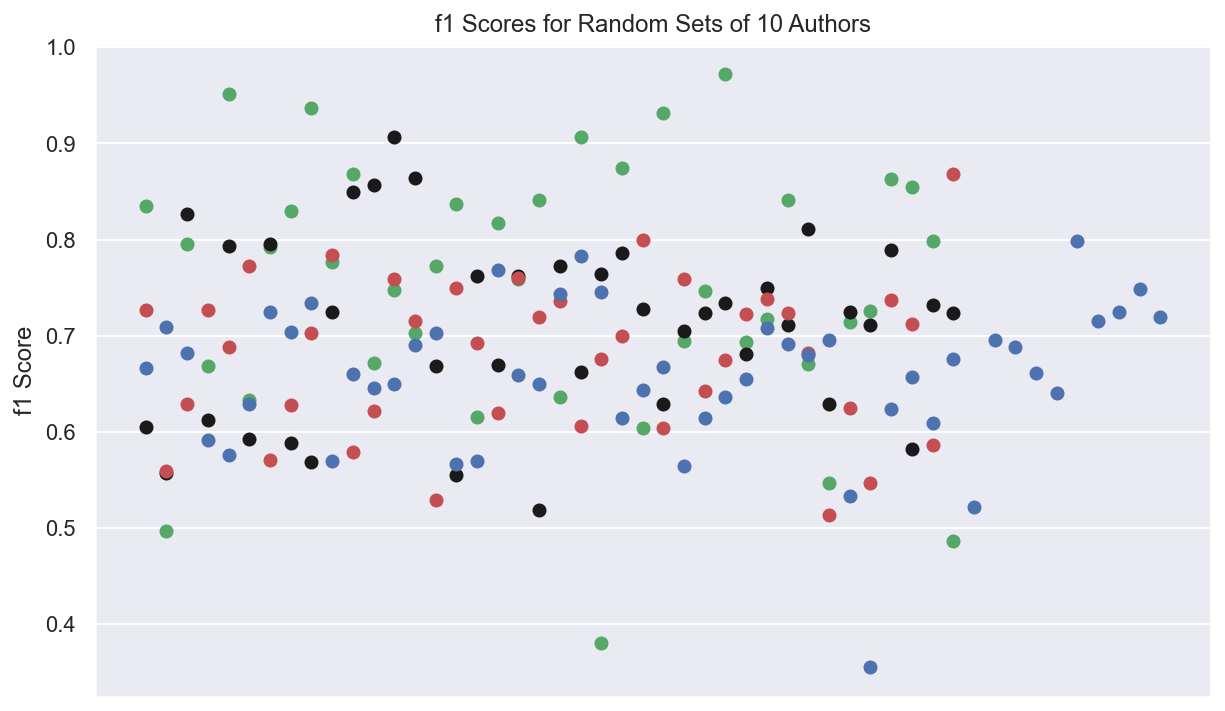

In [194]:
# plot the f1 values
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(list(range(len(f1_10))), f1_10, color='g')
ax.scatter(list(range(len(f1_20))), f1_20, color='k')
ax.scatter(list(range(len(f1_30))), f1_30, color='r')
ax.scatter(list(range(len(f1_40))), f1_40, color='b')
plt.title('f1 Scores for Random Sets of 10 Authors')
plt.ylabel('f1 Score')
plt.xticks([])

Huge range - lots of variance  
<hr>  

See if correlation b/w total num_posts and f-score

Text(0.5, 0, 'Total Number Posts')

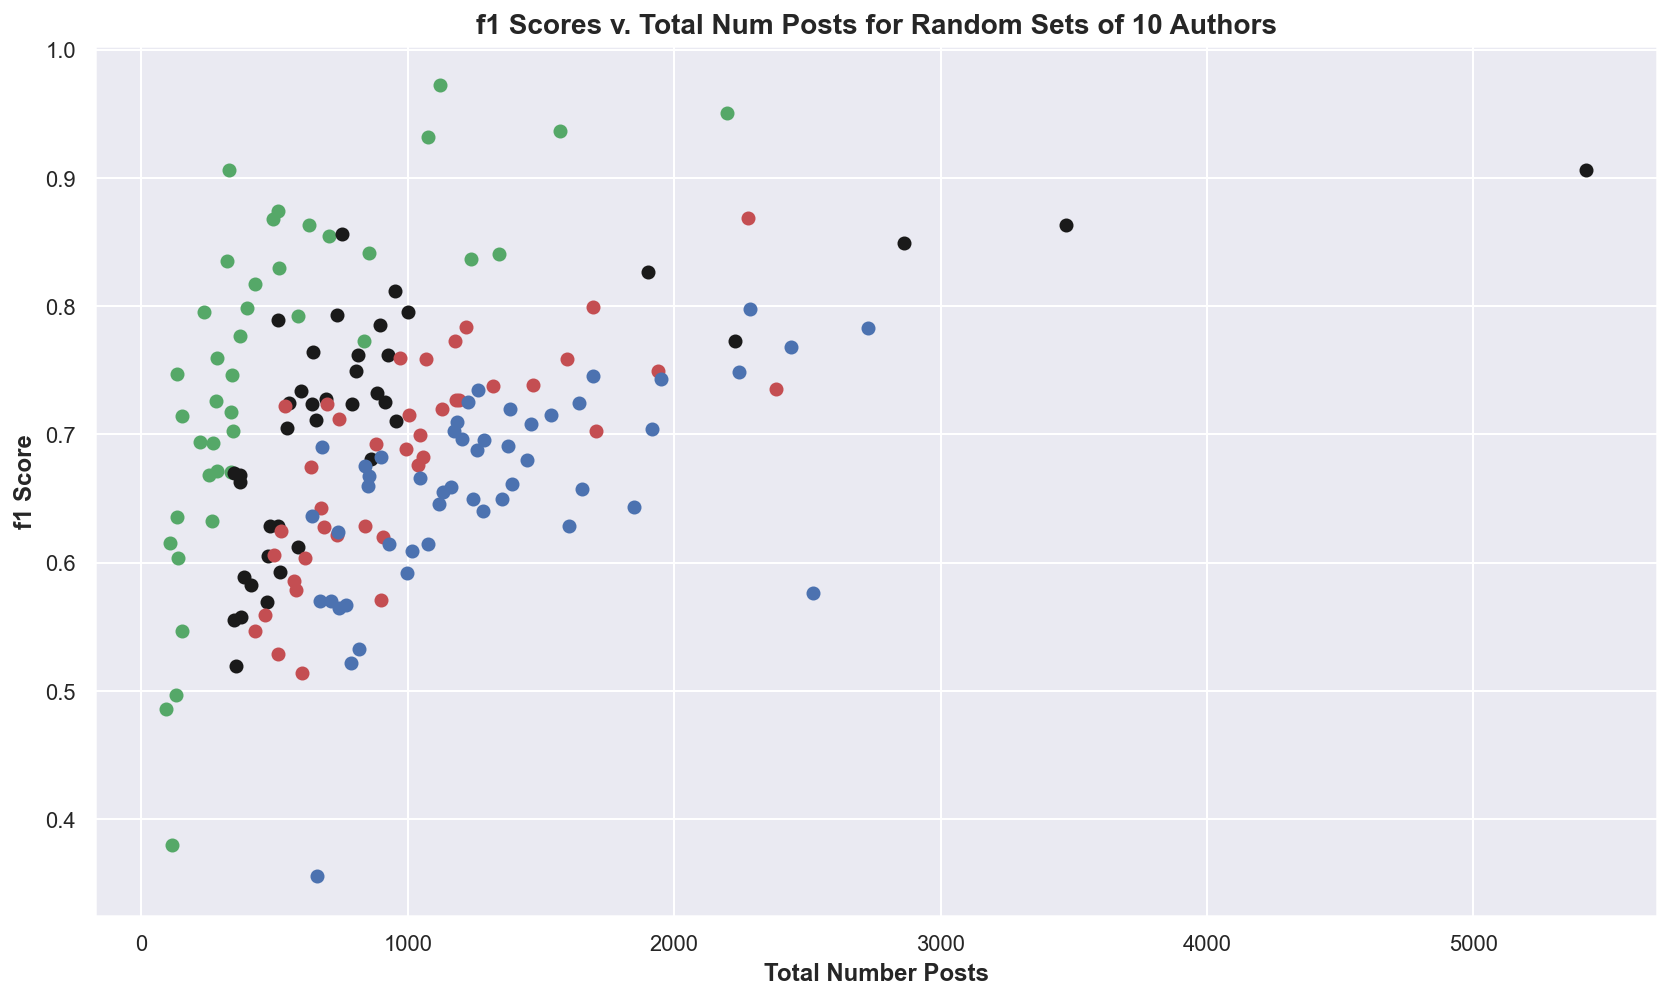

In [195]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(post_size_10, f1_10, color='g')
ax.scatter(post_size_20, f1_20, color='k')
ax.scatter(post_size_30, f1_30, color='r')
ax.scatter(post_size_40, f1_40, color='b')
plt.title('f1 Scores v. Total Num Posts for Random Sets of 10 Authors', size=14, weight='bold')
plt.ylabel('f1 Score', size=12, weight='bold')
plt.xlabel('Total Number Posts', size=12, weight='bold')

Observations:  
    - Trend as number of posts increases, f1 score increases, for all n in {10, 20, 30, 40}
    - so this is really normalizing for num_posts/author. 

Other Factors to consider:   
- some measurement of class (im)balance
- once we use more authors, maybe normalize by posts/author?
- or we could split posts up, e.g. by length??